In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

In [3]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [4]:
import os
# os.mkdir('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass')

## <font color='darkred'> TNG300-SAM

In [5]:
# Normalized SAM dataset; all masses divided by Mvir
# df_normalized = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/v6_TNG300-NewSAM_Normalized_Dataset_fromv1_wo_mstar9_nonphys_and_diskgals_w_smallfdsik_w_spineff.csv')

In [6]:
# Not normalized (raw) dataset
df_not_normalized = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/v6_TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineff.csv')

In [7]:
df_not_normalized.shape

(207467, 59)

In [8]:
df_not_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropMvir', 'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal',
       'GalpropRbulge', 'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropTsat', 'GalpropVdisk', 'GalpropZcold', 'GalpropZstar',
       'HalopropC_nfw', 'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropZhot', 'GalpropVvir',
       'GalpropMdisk', 'GalpropHalfRadius', 'HalopropVvir', 'GalpropLogMstar',
       'GalpropLogHalfRadius

In [9]:
df_not_normalized.loc[:, 'WeightedRadius'] = df_not_normalized.loc[:, 'BulgeMstar_ratio'] * \
            df_not_normalized.loc[:, 'GalpropRbulge'] + \
            1.68 * df_not_normalized.loc[:, 'DiskMstar_ratio'] * df_not_normalized.loc[:, 'GalpropRdisk']

### Weighted Radius vs Size

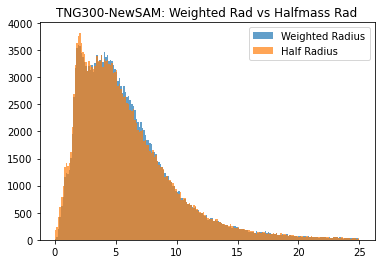

In [10]:
plt.hist(df_not_normalized.loc[:, 'WeightedRadius'], label='Weighted Radius', alpha=0.7, bins=200,range=(0, 25))
plt.hist(df_not_normalized.loc[:, 'GalpropHalfRadius'], label='Half Radius', alpha=0.7, bins=200, range=(0,25))
plt.title('TNG300-NewSAM: Weighted Rad vs Halfmass Rad')
plt.legend()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/TNG300_SAM_WeightedRad_vs_HalfRad.jpeg', dpi=500)
plt.show()

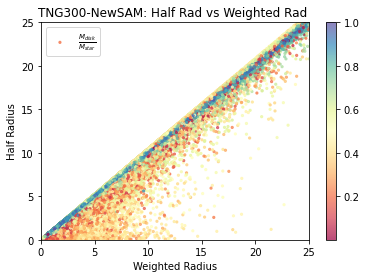

In [11]:
plt.scatter(df_not_normalized.loc[:, 'WeightedRadius'], df_not_normalized.loc[:, 'GalpropHalfRadius'], 
            c = df_not_normalized.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label=r'$\frac{M_{disk}}{M_{star}}$') #, vmin=0.005, vmax=0.04)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG300-NewSAM: Half Rad vs Weighted Rad ')
plt.legend(loc='upper left')
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/TNG300_SAM_halfrad_weightedrad_MdiskMstar_zoomin.jpeg', dpi=500)
plt.show()

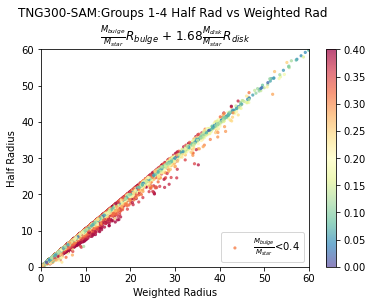

In [12]:
plt.scatter(df_not_normalized[df_not_normalized.BulgeMstar_ratio <= 0.40].loc[:, 'WeightedRadius'], df_not_normalized[df_not_normalized.BulgeMstar_ratio <= 0.40].loc[:, 'GalpropHalfRadius'], 
            c = df_not_normalized[df_not_normalized.BulgeMstar_ratio <= 0.40].loc[:,'BulgeMstar_ratio'],  cmap='Spectral_r',
            s=20, marker='.', alpha=0.7, label=r'$\frac{M_{bulge}}{M_{star}}$<0.4', vmin=0.0, vmax=0.4)
plt.xlabel('Weighted Radius')
plt.ylabel('Half Radius')
plt.title('TNG300-SAM:Groups 1-4 Half Rad vs Weighted Rad \n' + r'$\frac{M_{bulge}}{M_{star}}R_{bulge}$ + 1.68$\frac{M_{disk}}{M_{star}}R_{disk}$')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/TNG300_SAM_Groups14_halfrad_weightedrad_MbulgeMstar.jpeg', dpi=500)
plt.show()

## <font color='darkred'> TNG-SIM

In [13]:
# read TNG300-NewSIM (simulation) dataset
df_sim = pd.read_hdf ('/Users/festabu/Desktop/ML_galaxy_size_project/Codes/TNG_Data_SAM_and_SIM/data/tng300-sim.h5') 

In [14]:
df_sim

,SubhaloBHMass,SubhaloBHMdot,SubhaloGasMetallicity,SubhaloMass,SubhaloSFRinRad,SubhaloStarMetallicity,SubhaloVelDisp,SubhaloVmax,SubhaloVmaxRad,SubhaloRgas,...,GroupMass,Group_M_Crit200,Group_M_TopHat200,Group_R_Crit200,Group_R_TopHat200,SubhaloIndexDark_LHaloTree,SubhaloIndexDark_SubLink,is_primary,SubhaloMHI,SubhaloMH2
0,4.221201e+10,2.379880e-03,0.003206,1.734251e+15,0.0,0.020017,969.997864,1744.130371,774.482438,1285.803833,...,2.622176e+15,1.405870e+15,1.699643e+15,2226.926758,2965.847656,0,0,True,2.142094e+09,7.510782e+08
1,1.733208e+10,4.785838e-04,0.003881,4.909904e+14,0.0,0.017918,756.414368,1314.501709,884.313140,663.347778,...,2.622176e+15,1.405870e+15,1.699643e+15,2226.926758,2965.847656,1,1,False,2.832255e+05,3.868605e-09
2,3.706509e+09,6.864212e-07,0.000000,1.211357e+13,0.0,0.025681,332.968567,516.609375,4.398453,0.000000,...,2.622176e+15,1.405870e+15,1.699643e+15,2226.926758,2965.847656,5,5,False,0.000000e+00,0.000000e+00
3,1.646713e+09,3.379718e-08,0.000000,6.689004e+12,0.0,0.019654,212.599594,381.981842,64.534595,0.000000,...,2.622176e+15,1.405870e+15,1.699643e+15,2226.926758,2965.847656,8,8,False,0.000000e+00,0.000000e+00
4,8.421277e+08,2.567453e-08,0.000000,6.317082e+12,0.0,0.020799,243.636978,400.381042,91.623296,0.000000,...,2.622176e+15,1.405870e+15,1.699643e+15,2226.926758,2965.847656,7,7,False,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485704,0.000000e+00,0.000000e+00,0.000000,1.399583e+09,0.0,0.000000,8.982152,18.240549,5.567968,0.000000,...,1.450304e+09,9.151117e+08,9.689418e+08,19.299562,24.592482,14824567,14824567,NaN,NaN,NaN
14485705,0.000000e+00,0.000000e+00,0.000000,1.453413e+09,0.0,0.000000,9.221106,16.537081,16.935378,0.000000,...,1.544677e+09,1.291922e+09,1.410316e+09,21.651791,27.870779,15407825,15407825,NaN,NaN,NaN
14485706,0.000000e+00,0.000000e+00,0.000000,1.453413e+09,0.0,0.000000,9.148104,19.764599,8.891967,0.000000,...,1.504992e+09,1.135680e+09,1.297170e+09,20.740507,27.104431,12141508,12141508,NaN,NaN,NaN
14485707,0.000000e+00,0.000000e+00,0.000000,1.399583e+09,0.0,0.000000,8.639939,17.153547,14.165999,0.000000,...,1.458609e+09,1.130432e+09,1.184262e+09,20.707359,26.294682,-1,-1,NaN,NaN,NaN


In [15]:
# Remove all galaxies with logMstar < 8
df_sim = df_sim[df_sim.SubhaloMstar>1e8]

In [16]:
df_sim.shape

(528428, 41)

In [17]:
df_sim.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloGasMetallicity',
       'SubhaloMass', 'SubhaloSFRinRad', 'SubhaloStarMetallicity',
       'SubhaloVelDisp', 'SubhaloVmax', 'SubhaloVmaxRad', 'SubhaloRgas',
       'SubhaloRstar', 'SubhaloMgas', 'SubhaloMstar', 'SubhaloX', 'SubhaloVx',
       'SubhaloJx', 'SubhaloY', 'SubhaloVy', 'SubhaloJy', 'SubhaloZ',
       'SubhaloVz', 'SubhaloJz', 'SubhaloCentral', 'GroupNsubs', 'GroupX',
       'GroupVx', 'GroupY', 'GroupVy', 'GroupZ', 'GroupVz', 'GroupBHMass',
       'GroupMass', 'Group_M_Crit200', 'Group_M_TopHat200', 'Group_R_Crit200',
       'Group_R_TopHat200', 'SubhaloIndexDark_LHaloTree',
       'SubhaloIndexDark_SubLink', 'is_primary', 'SubhaloMHI', 'SubhaloMH2'],
      dtype='object')>

In [18]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v_sim = Mvir_to_Vvir (np.array(df_sim.loc[:,'SubhaloMass']),0) # has units
# Q: Why SubhaloMass and not SubhaloMstar??

In [19]:
v_sim

<Quantity [1541.03570679, 1011.88933251,  294.57739868, ...,    7.43989847,
              7.38741658,    7.03945158] km / s>

In [20]:
# add Halo property Vvir
df_sim.loc[:, 'SubhaloVvir']=v_sim.value 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### <font color='orangered'> Q: Is SubhaloCentral 0 for centrals and 1 for satellites??
    Ans by Ari: SubhaloCentral==1 for central galaxies (true for centrals, false for satellites). So let's choose only central galaxies.

In [21]:
df_sim['SubhaloCentral'].value_counts()

1    320548
0    207880
Name: SubhaloCentral, dtype: int64

In [22]:
df_sim.shape

(528428, 42)

In [23]:
# choose only central galaxies from SIM
df_sim = df_sim[df_sim.SubhaloCentral==1]

In [24]:
df_sim.shape

(320548, 42)

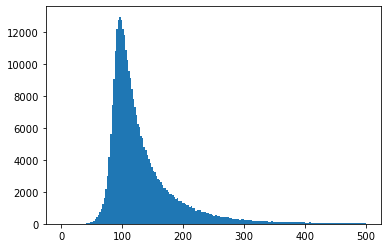

In [25]:
plt.hist(df_sim.loc[:, 'Group_R_Crit200'], bins=200, range=(0, 500))
plt.show()

#### Add spin to TNG-SIM: lambda = sqrt(Jx^2 + Jy^2 + Jz^2) /over sqrt(2) Mvir Rvir.

In [26]:
def spin_func(jx, jy, jz, Mvir, Rvir, Vvir):
    
#     spin = np.sqrt(jx**2 + jy**2 + jz**2)/(np.sqrt(2)*Mvir*Rvir*Vvir)
    spin = np.sqrt(jx**2 + jy**2 + jz**2)/(np.sqrt(2)*Rvir*Vvir)
   
    # Spin from TNG-SIM has units kpc*km/s which is not J or spin. 
    # It would indicate that it is J/M (it is specific spin; spin per mass). 
    # Therefore, do not divide by Mvir in the formula.

    return spin
    

In [27]:

df_sim.loc[:,'SubhaloSpin'] = df_sim.apply(lambda x: spin_func(jx=x['SubhaloJx'],
                                                                         jy=x['SubhaloJy'],
                                                                         jz=x['SubhaloJz'],
                                                                         Mvir=x['SubhaloMass'],
                                                                         Rvir=x['Group_R_Crit200'],
                                                                         Vvir=x['SubhaloVvir']), axis=1)

In [28]:
df_sim.shape

(320548, 43)

In [29]:
df_sim.loc[:,'SubhaloLogMstar']=df_sim.loc[:,'SubhaloMstar'].apply(lambda x: np.log10(x) if x>0 else 0)


In [30]:
df_sim.loc[:,'SubhaloLogRstar']=df_sim.loc[:,'SubhaloRstar'].apply(lambda x: np.log10(x) if x>0 else 0)



In [31]:
df_sim.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloX',
 'SubhaloVx',
 'SubhaloJx',
 'SubhaloY',
 'SubhaloVy',
 'SubhaloJy',
 'SubhaloZ',
 'SubhaloVz',
 'SubhaloJz',
 'SubhaloCentral',
 'GroupNsubs',
 'GroupX',
 'GroupVx',
 'GroupY',
 'GroupVy',
 'GroupZ',
 'GroupVz',
 'GroupBHMass',
 'GroupMass',
 'Group_M_Crit200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_TopHat200',
 'SubhaloIndexDark_LHaloTree',
 'SubhaloIndexDark_SubLink',
 'is_primary',
 'SubhaloMHI',
 'SubhaloMH2',
 'SubhaloVvir',
 'SubhaloSpin',
 'SubhaloLogMstar',
 'SubhaloLogRstar']

In [32]:
df_sim.SubhaloLogMstar.max()

12.782191719746237

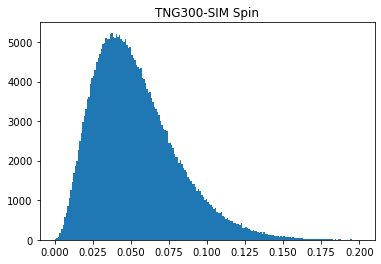

In [34]:
plt.hist(df_sim.loc[:, 'SubhaloSpin'], bins=200, range=(0, 0.2))
plt.title('TNG300-SIM Spin')
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_spin_histogram.jpeg', dpi=500)
plt.show()

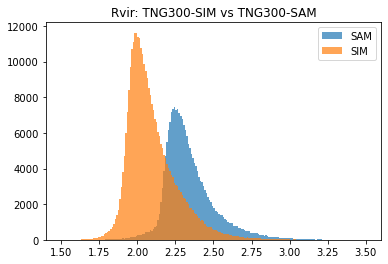

In [36]:
# plt.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200']), label='SIM', alpha=0.7) 
plt.hist(np.log10(df_not_normalized.loc[:, 'GalpropRhalo']), label='SAM', alpha=0.7, bins=200, range=(1.5, 3.5))
plt.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200']), label='SIM', alpha=0.7, bins=200, range=(1.5, 3.5)) 
plt.title('Rvir: TNG300-SIM vs TNG300-SAM')
plt.legend()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_vs_SAM_Rvir_histogram.jpeg', dpi=500)
plt.show()

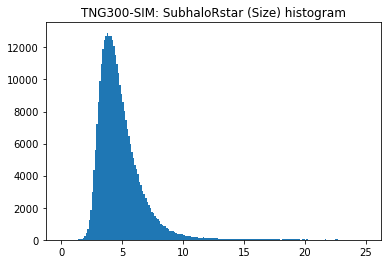

In [37]:
plt.hist(df_sim.loc[:, 'SubhaloRstar'], range=(0, 25), bins=200)
plt.title('TNG300-SIM: SubhaloRstar (Size) histogram')
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_Rstar_histogram.jpeg', dpi=500)
plt.show()

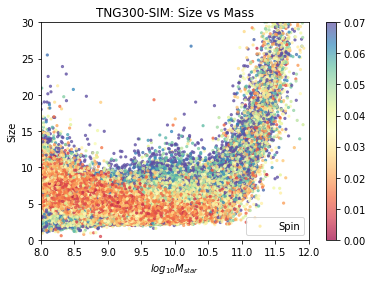

In [42]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), df_sim.loc[:, 'SubhaloRstar'],
            c = df_sim.loc[:,'SubhaloSpin'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Spin', vmin=0.0, vmax=0.07)
plt.xlabel(r'$log_{10}M_{star}$')
plt.ylabel('Size')
plt.ylim(0,30)
plt.xlim(8, 12)
plt.title('TNG300-SIM: Size vs Mass')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_size_mass.jpeg', dpi=500)
plt.show()

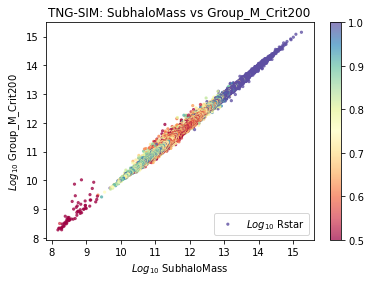

In [44]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMass']), np.log10(df_sim.loc[:, 'Group_M_Crit200']),
            c = np.log10(df_sim.loc[:,'SubhaloRstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='$ Log_{10} $ Rstar', vmin=0.5, vmax=1.0)
plt.xlabel('$ Log_{10} $ SubhaloMass')
plt.ylabel('$ Log_{10} $ Group_M_Crit200')
plt.title('TNG-SIM: SubhaloMass vs Group_M_Crit200')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SubhaloMass_vs_Group_M_Crit200.jpeg', dpi=500)
plt.show()

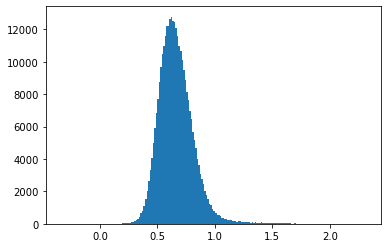

In [45]:
plt.hist(np.log10(df_sim.loc[:,'SubhaloRstar']), bins=200)
plt.show()

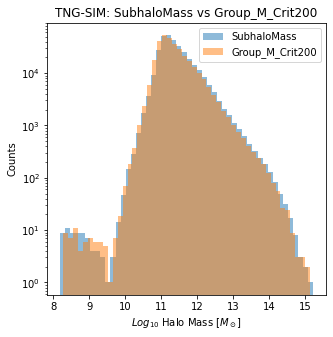

In [47]:
fig1,(ax1)=plt.subplots(nrows=1,ncols=1,figsize=(5,5))

ax1.hist(np.log10(df_sim.loc[:,'SubhaloMass']), bins=50, log=True, alpha=0.5, label='SubhaloMass')
ax1.hist(np.log10(df_sim.loc[:,'Group_M_Crit200']), bins=50, log=True, alpha=0.5, label='Group_M_Crit200')
ax1.set_title('TNG-SIM: SubhaloMass vs Group_M_Crit200')
ax1.set_xlabel('$ Log_{10} $ Halo Mass [$ M_\odot $]')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

# plt.savefig("TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SubhaloMass_vs_Group_M_crit200_Hist1D.jpeg", dpi=500)
plt.show()

### <font color='blue'> Define TNG300-SIM to only include galaxies with $log_{10}M_{star}$>9.0 so that SAM and SIM have similar mass cutting

In [48]:
# Remove all galaxies with logMstar < 8
df_sim = df_sim[df_sim.SubhaloMstar>1e9]

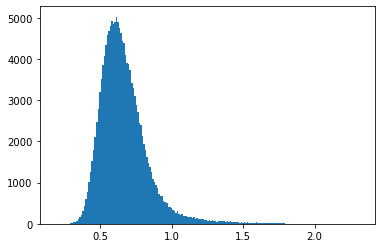

In [49]:
plt.hist(np.log10(df_sim.loc[:,'SubhaloRstar']), bins=200)
plt.show()

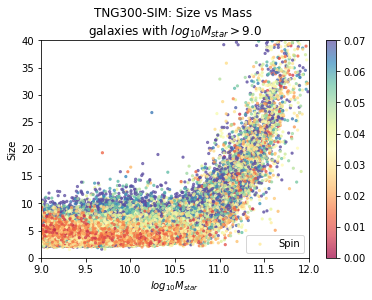

In [53]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), df_sim.loc[:, 'SubhaloRstar'],
            c = df_sim.loc[:,'SubhaloSpin'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='Spin', vmin=0.0, vmax=0.07)
plt.xlabel(r'$log_{10}M_{star}$')
plt.ylabel('Size')
plt.ylim(0,40)
plt.xlim(9, 12)
plt.title('TNG300-SIM: Size vs Mass \n' + r'galaxies with $log_{10}M_{star}>9.0$')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_size_mass_wolog10Mstar8gals.jpeg', dpi=500)
plt.show()

## <font color='darkblue'> TNG SIM vs SAM histograms

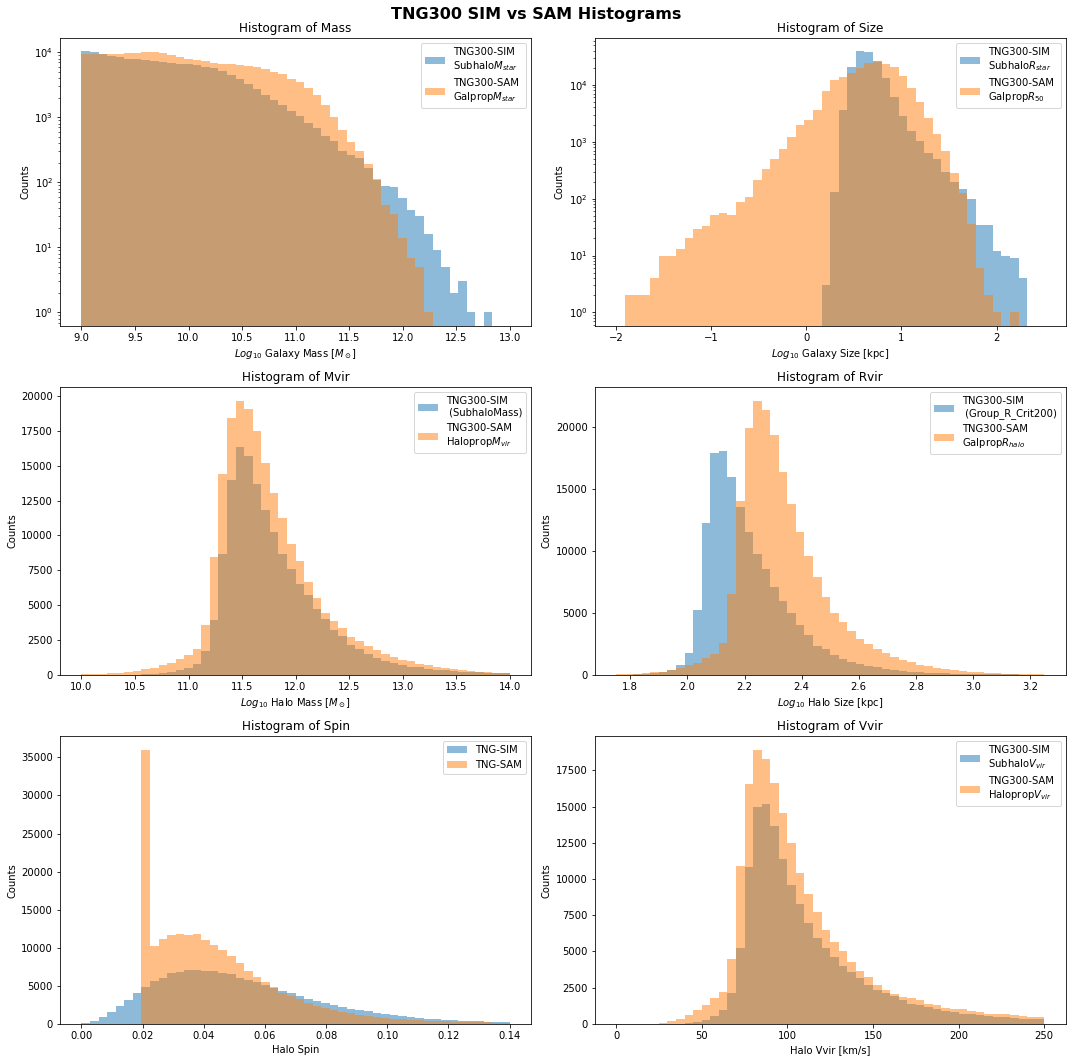

In [59]:
fig,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(15,15))
fig.suptitle('TNG300 SIM vs SAM Histograms', fontsize=16, fontweight='bold')


ax1.hist(np.log10(df_sim.loc[:, 'SubhaloMstar']), bins=50, range=(9, 13),
         log=True, alpha=0.5, label='TNG300-SIM \n' + r'Subhalo$M_{star}$')
ax1.hist(df_not_normalized.loc[:, 'GalpropLogMstar'], bins=50, range=(9, 13),
         log=True, alpha=0.5, label='TNG300-SAM \n' + r'Galprop$M_{star}$')
ax1.set_title('Histogram of Mass')
ax1.set_xlabel('$ Log_{10} $ Galaxy Mass [$ M_\odot $]')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(np.log10(df_sim.loc[:, 'SubhaloRstar']),bins=50, range=(-2, 2.5),
         log=True, alpha=0.5, label='TNG300-SIM \n' + r'Subhalo$R_{star}$')
ax2.hist(np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']), bins=50, range=(-2, 2.5),
         log=True, alpha=0.5, label='TNG300-SAM \n' + r'Galprop$R_{50}$')
ax2.set_title('Histogram of Size')
ax2.set_xlabel('$ Log_{10} $ Galaxy Size [kpc]')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(np.log10(df_sim.loc[:, 'SubhaloMass']), bins=50, range=(10, 14),
         alpha=0.5, label='TNG300-SIM \n (SubhaloMass)')
ax3.hist(np.log10(df_not_normalized.loc[:, 'HalopropMvir']), bins=50, range=(10, 14),
         alpha=0.5, label='TNG300-SAM \n' + r'Haloprop$M_{vir}$')
ax3.set_title('Histogram of Mvir')
ax3.set_xlabel('$ Log_{10} $ Halo Mass [$ M_\odot $]')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(np.log10(df_sim.loc[:, 'Group_R_Crit200']), bins=50, range=(1.75, 3.25),
         alpha=0.5, label='TNG300-SIM \n (Group_R_Crit200)')
ax4.hist(np.log10(df_not_normalized.loc[:, 'GalpropRhalo']), bins=50, range=(1.75, 3.25),
         alpha=0.5, label='TNG300-SAM \n' + r'Galprop$R_{halo}$')
ax4.set_title('Histogram of Rvir')
ax4.set_xlabel('$ Log_{10} $ Halo Size [kpc]')
ax4.set_ylabel('Counts')
ax4.legend(loc='upper right')

ax5.hist(df_sim.loc[:, 'SubhaloSpin'], bins=50, range=(0, 0.14),
         alpha=0.5, label='TNG-SIM')
ax5.hist(df_not_normalized.loc[:, 'HalopropSpin'], bins=50, range=(0, 0.14),
         alpha=0.5, label='TNG-SAM')
ax5.set_title('Histogram of Spin')
ax5.set_xlabel('Halo Spin')
ax5.set_ylabel('Counts')
ax5.legend(loc='upper right')

ax6.hist(df_sim.loc[:, 'SubhaloVvir'], bins=50, alpha=0.5, range=(0, 250),
         label='TNG300-SIM \n' + r'Subhalo$V_{vir}$')
ax6.hist(df_not_normalized.loc[:, 'HalopropVvir'], bins=50, range=(0, 250),
         alpha=0.5, label='TNG300-SAM \n' + r'Haloprop$V_{vir}$')
ax6.set_title('Histogram of Vvir')
ax6.set_xlabel('Halo Vvir [km/s]')
ax6.set_ylabel('Counts')
ax6.legend(loc='upper right')

fig.tight_layout()
# plt.savefig("TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_vs_SAM_histograms_mass_size_halomass_size_spin_vvir.jpeg", dpi=500)
plt.show()

## <font color='darkblue'> TNG SIM vs SAM: size mass plot

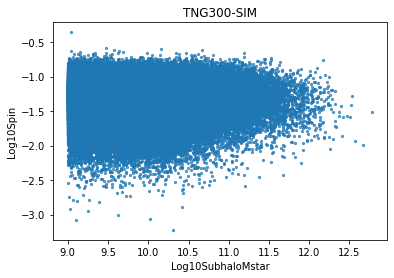

In [63]:
plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloSpin']),
           s=20, marker='.', alpha=0.7, label='SIM')
plt.title('TNG300-SIM')
plt.xlabel('Log10SubhaloMstar')
plt.ylabel('Log10Spin')
plt.show()

##### Conclusion of above plots: Very low spin galaxies span all mass ranges

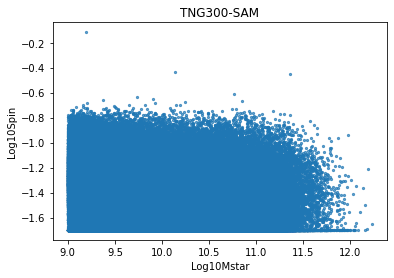

In [64]:
plt.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:,'HalopropSpin']),
           s=20, marker='.', alpha=0.7, label='SAM')
plt.title('TNG300-SAM')
plt.xlabel('Log10Mstar')
plt.ylabel('Log10Spin')
plt.show()

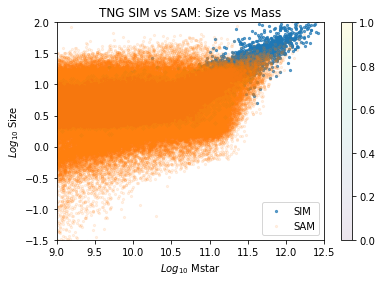

In [66]:


plt.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloRstar']),
           s=20, marker='.', alpha=0.7, label='SIM')
plt.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']),
           s=20, marker='.', alpha=0.1, label='SAM') 
plt.xlabel('$ Log_{10} $ Mstar')
plt.ylabel('$ Log_{10} $ Size')
plt.xlim(9, 12.5)
plt.ylim(-1.5, 2)
plt.title('TNG SIM vs SAM: Size vs Mass')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG-SIM_SubhaloMass_vs_Group_M_Crit200.jpeg', dpi=500)
plt.show()

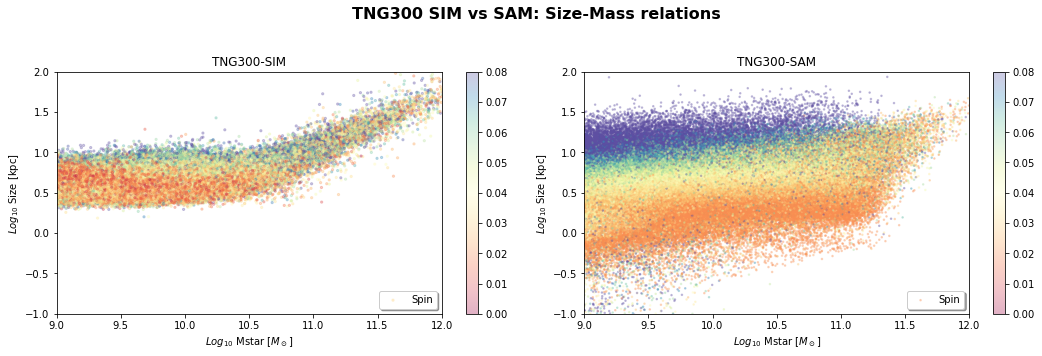

In [71]:
fig_all,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig_all.suptitle('TNG300 SIM vs SAM: Size-Mass relations', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloRstar']),
            c = df_sim.loc[:,'SubhaloSpin'],  cmap='Spectral',
            s=20, marker='.', alpha=0.3, label='Spin', vmin=0.0, vmax=0.08)
ax1.set_title('TNG300-SIM')
ax1.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax1.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax1.set_xlim([9.0,12.0])
ax1.set_ylim([-1.0,2.0])
ax1.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']),
            c = df_not_normalized.loc[:,'HalopropSpin'],  cmap='Spectral',
            s=10, marker='.', alpha=0.3,label='Spin', vmin=0.0, vmax=0.08)
ax2.set_title('TNG300-SAM')
ax2.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax2.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax2.set_xlim([9.0,12.0])
ax2.set_ylim([-1.0,2.0])
ax2.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_2, ax=ax2)

fig_all.tight_layout()
fig_all.subplots_adjust(top=0.8, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_vs_SAM_Size_vs_Mass.jpeg", dpi=500)
plt.show()

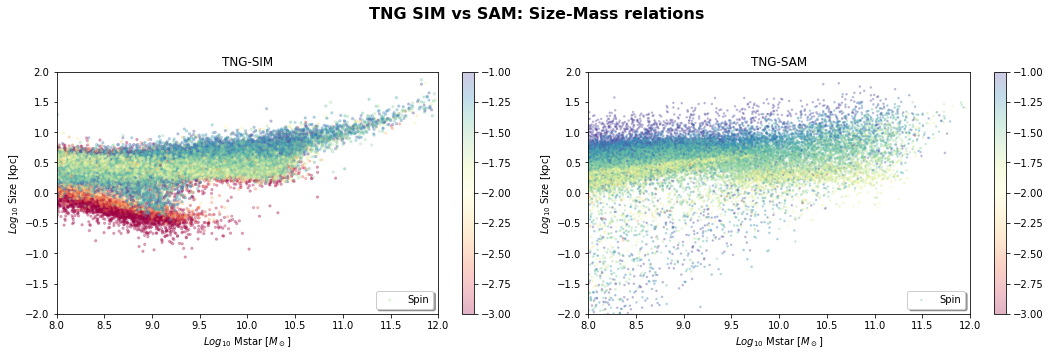

In [46]:
fig_all,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig_all.suptitle('TNG SIM vs SAM: Size-Mass relations', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(np.log10(df_sim.loc[:, 'SubhaloMstar']), np.log10(df_sim.loc[:,'SubhaloRstar']),
            c = np.log10(df_sim.loc[:,'SubhaloSpin']),  cmap='Spectral',
            s=20, marker='.', alpha=0.3, label='Spin', vmin=-3.0, vmax=-1)
ax1.set_title('TNG-SIM')
ax1.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax1.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax1.set_xlim([8.0,12.0])
ax1.set_ylim([-2.0,2.0])
ax1.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_not_normalized.loc[:, 'GalpropLogMstar'], np.log10(df_not_normalized.loc[:, 'GalpropHalfRadius']),
            c = np.log10(df_not_normalized.loc[:,'HalopropSpin']),  cmap='Spectral',
            s=10, marker='.', alpha=0.3,label='Spin', vmin=-3.0, vmax=-1)
ax2.set_title('TNG-SAM')
ax2.set_xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
ax2.set_ylabel('$ Log_{10} $ Size [kpc] ')
ax2.set_xlim([8.0,12.0])
ax2.set_ylim([-2.0,2.0])
ax2.legend(loc = 'lower right', shadow=True)
fig_all.colorbar(fig_2, ax=ax2)

fig_all.tight_layout()
fig_all.subplots_adjust(top=0.8, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SIM-SAM_Size_vs_Mass.jpeg", dpi=500)
plt.show()

## <font color='darkviolet'> TNG SIM & SAM: Divide dataset by LogMstar bins

### <font color='darkviolet'> TNG SIM

In [72]:
df_sim_8_9 = df_sim[df_sim.SubhaloLogMstar < 9.0]

In [73]:
df_sim_8_9.shape

(0, 45)

In [74]:
df_sim_9_10 = df_sim[(df_sim.SubhaloLogMstar >= 9.0) & (df_sim.SubhaloLogMstar < 10.0)]

In [75]:
df_sim_9_10.shape

(101434, 45)

In [76]:
df_sim_10_11 = df_sim[(df_sim.SubhaloLogMstar >= 10.0) & (df_sim.SubhaloLogMstar < 11.0)]

In [77]:
df_sim_10_11.shape

(47617, 45)

In [78]:
df_sim_11_12 = df_sim[(df_sim.SubhaloLogMstar >= 11.0) & (df_sim.SubhaloLogMstar < 12.0)]

In [79]:
df_sim_11_12.shape

(4767, 45)

In [80]:
df_sim_11_12.loc[:, 'SubhaloLogMstar'].max()

11.999268936457316

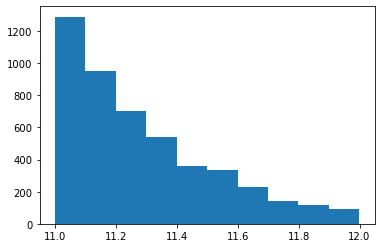

In [81]:
plt.hist(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
plt.show()

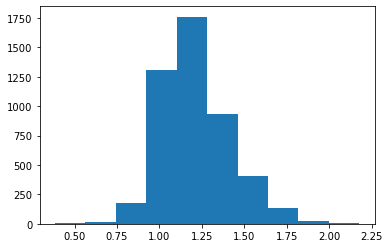

In [82]:
plt.hist(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
plt.show()

In [83]:
df_sim_12_13 = df_sim[df_sim.SubhaloLogMstar >= 12.0]

In [84]:
df_sim_12_13.shape

(128, 45)

In [85]:
df_sim_12_13.loc[:, 'SubhaloLogMstar'].max()

12.782191719746237

### <font color='darkviolet'> TNG SAM

In [86]:
df_sam_8_9 = df_not_normalized[df_not_normalized.GalpropLogMstar < 9.0]

In [87]:
df_sam_8_9.shape

(0, 60)

In [88]:
df_sam_9_10 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 9.0) &
                                (df_not_normalized.GalpropLogMstar < 10.0)]

In [89]:
df_sam_9_10.shape

(118178, 60)

In [90]:
df_sam_10_11 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 10.0) &
                                (df_not_normalized.GalpropLogMstar < 11.0)]

In [91]:
df_sam_10_11.shape

(76496, 60)

In [92]:
df_sam_11_12 = df_not_normalized[(df_not_normalized.GalpropLogMstar >= 11.0) &
                                (df_not_normalized.GalpropLogMstar < 12.0)]

In [93]:
df_sam_11_12.shape

(12776, 60)

In [94]:
df_sam_11_12.loc[:, 'GalpropLogMstar'].max()

11.997750612720171

In [95]:
df_sam_12_13 = df_not_normalized[df_not_normalized.GalpropLogMstar >= 12.0]

In [96]:
df_sam_12_13.shape

(17, 60)

In [97]:
df_sam_12_13.loc[:, 'GalpropLogMstar'].max()

12.231658149066083

### <font color='darkviolet'> TNG SIM & SAM: Find mean Mstar value for each bin

#### <font color='darkviolet'> TNG SIM

In [98]:
# mean Log Mstar in bin 8-9
sim_mMstar_8_9 = np.mean(df_sim_8_9.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_8_9)

nan


In [99]:
sim_mMstar_9_10 = np.mean(df_sim_9_10.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_9_10)

9.459537506728886


In [100]:
sim_mMstar_10_11 = np.mean(df_sim_10_11.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_10_11)

10.36554098359453


In [101]:
sim_mMstar_11_12 = np.mean(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_11_12)

11.28446550506731


In [102]:
sim_mMstar_12_13 = np.mean(df_sim_12_13.loc[:, 'SubhaloLogMstar'])
print(sim_mMstar_12_13)

12.161063863367506


In [103]:
# std Log Mstar in bin 8-9
sim_stdMstar_8_9 = np.std(df_sim_8_9.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_8_9)

nan


In [104]:
sim_stdMstar_9_10 = np.std(df_sim_9_10.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_9_10)

0.2898345498682057


In [105]:
sim_stdMstar_10_11 = np.std(df_sim_10_11.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_10_11)

0.2562112211583473


In [106]:
sim_stdMstar_11_12 = np.std(df_sim_11_12.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_11_12)

0.23663858117448647


In [107]:
sim_stdMstar_12_13 = np.std(df_sim_12_13.loc[:, 'SubhaloLogMstar'])
print(sim_stdMstar_12_13)

0.14360381648242582


In [108]:
# mean Log Size in bin 8-9
sim_mRstar_8_9 = np.mean(df_sim_8_9.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_8_9)

nan


In [109]:
sim_mRstar_9_10 = np.mean(df_sim_9_10.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_9_10)

0.623032223873509


In [110]:
sim_mRstar_10_11 = np.mean(df_sim_10_11.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_10_11)

0.7063145153190138


In [111]:
sim_mRstar_11_12 = np.mean(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_11_12)

1.2117607111808004


In [112]:
sim_mRstar_12_13 = np.mean(df_sim_12_13.loc[:, 'SubhaloLogRstar'])
print(sim_mRstar_12_13)

1.8251230120275475


In [113]:
# std Log Rstar in bin 8-9
sim_stdRstar_8_9 = np.std(df_sim_8_9.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_8_9)

sim_stdRstar_9_10 = np.std(df_sim_9_10.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_9_10)

sim_stdRstar_10_11 = np.std(df_sim_10_11.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_10_11)

sim_stdRstar_11_12 = np.std(df_sim_11_12.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_11_12)

sim_stdRstar_12_13 = np.std(df_sim_12_13.loc[:, 'SubhaloLogRstar'])
print(sim_stdRstar_12_13)

nan
0.11858482441336701
0.14509550144684735
0.20368271682108083
0.18500500844646137


#### <font color='darkviolet'> TNG SAM

In [114]:
# mean Log Mstar in bin 8-9
sam_mMstar_8_9 = np.mean(df_sam_8_9.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_8_9)

nan


In [115]:
sam_mMstar_9_10 = np.mean(df_sam_9_10.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_9_10)

9.496222974253115


In [116]:
sam_mMstar_10_11 = np.mean(df_sam_10_11.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_10_11)

10.449265502120923


In [117]:
sam_mMstar_11_12 = np.mean(df_sam_11_12.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_11_12)

11.208054481293535


In [118]:
sam_mMstar_12_13 = np.mean(df_sam_12_13.loc[:, 'GalpropLogMstar'])
print(sam_mMstar_12_13)

12.093337894048162


In [119]:
# std Log Mstar in bin 8-9
sam_stdMstar_8_9 = np.std(df_sam_8_9.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_8_9)

nan


In [120]:
sam_stdMstar_9_10 = np.std(df_sam_9_10.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_9_10)

0.28380136316846893


In [121]:
sam_stdMstar_10_11 = np.std(df_sam_10_11.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_10_11)

0.28090159586114827


In [122]:
sam_stdMstar_11_12 = np.std(df_sam_11_12.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_11_12)

sam_stdMstar_12_13 = np.std(df_sam_12_13.loc[:, 'GalpropLogMstar'])
print(sam_stdMstar_12_13)

0.17520848486435608
0.06507308194979468


In [123]:
# mean Log Rstar in bin 8-9
sam_mRstar_8_9 = np.mean(df_sam_8_9.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_8_9)

nan


In [124]:
sam_mRstar_9_10 = np.mean(df_sam_9_10.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_9_10)

0.6364620504067134


In [125]:
sam_mRstar_10_11 = np.mean(df_sam_10_11.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_10_11)

0.6833001748068962


In [126]:
sam_mRstar_11_12 = np.mean(df_sam_11_12.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_11_12)

sam_mRstar_12_13 = np.mean(df_sam_11_12.loc[:, 'GalpropLogHalfRadius'])
print(sam_mRstar_12_13)

0.8613343298299285
0.8613343298299285


In [127]:
# std Log Rstar in bin 8-9
sam_stdRstar_8_9 = np.std(df_sam_8_9.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_8_9)

sam_stdRstar_9_10 = np.std(df_sam_9_10.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_9_10)

sam_stdRstar_10_11 = np.std(df_sam_10_11.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_10_11)

sam_stdRstar_11_12 = np.std(df_sam_11_12.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_11_12)

sam_stdRstar_12_13 = np.std(df_sam_12_13.loc[:, 'GalpropLogHalfRadius'])
print(sam_stdRstar_12_13)

nan
0.31949600910025044
0.3131424684082204
0.3284259918988693
0.12056905811456181


#### Arrays

In [128]:
sim_mMstar = np.array([sim_mMstar_8_9, sim_mMstar_9_10, sim_mMstar_10_11, sim_mMstar_11_12, sim_mMstar_12_13])

print(sim_mMstar)

sim_stdMstar = np.array([sim_stdMstar_8_9, sim_stdMstar_9_10, sim_stdMstar_10_11, sim_stdMstar_11_12,  sim_stdMstar_12_13])

sim_mRstar = np.array([sim_mRstar_8_9, sim_mRstar_9_10, sim_mRstar_10_11, sim_mRstar_11_12, sim_mRstar_12_13])

print(sim_mRstar)

sim_stdRstar = np.array([sim_stdRstar_8_9, sim_stdRstar_9_10, sim_stdRstar_10_11, sim_stdRstar_11_12, sim_stdRstar_12_13])

print(sim_stdRstar)

In [135]:
sam_mMstar = np.array([sam_mMstar_8_9, sam_mMstar_9_10, sam_mMstar_10_11, sam_mMstar_11_12, sam_mMstar_12_13])

print(sam_mMstar)

sam_stdMstar = np.array([sam_stdMstar_8_9, sam_stdMstar_9_10, sam_stdMstar_10_11, sam_stdMstar_11_12, sam_stdMstar_12_13])

sam_mRstar = np.array([sam_mRstar_8_9, sam_mRstar_9_10, sam_mRstar_10_11, sam_mRstar_11_12, sam_mRstar_12_13])

sam_stdRstar = np.array([sam_stdRstar_8_9, sam_stdRstar_9_10, sam_stdRstar_10_11, sam_stdRstar_11_12, sam_stdRstar_12_13])

In [140]:
sam_stdRstar

array([       nan, 0.31949601, 0.31314247, 0.32842599, 0.12056906])

In [141]:
sam_mRstar

array([       nan, 0.63646205, 0.68330017, 0.86133433, 0.86133433])

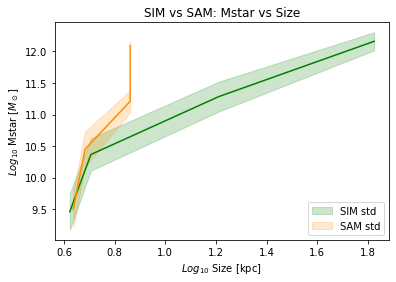

In [142]:
plt.plot(sim_mRstar, sim_mMstar, '-', color='green')

plt.fill_between(sim_mRstar, sim_mMstar - sim_stdMstar, sim_mMstar + sim_stdMstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mRstar, sam_mMstar, '-', color='darkorange')

plt.fill_between(sam_mRstar, sam_mMstar - sam_stdMstar, sam_mMstar + sam_stdMstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('SIM vs SAM: Mstar vs Size')
plt.ylabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.xlabel('$ Log_{10} $ Size [kpc] ')
plt.legend()
plt.show()


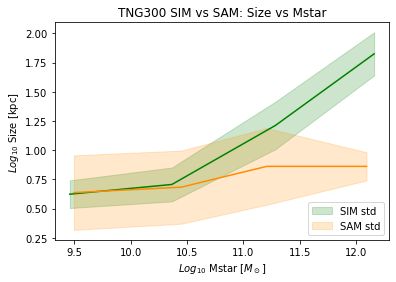

In [144]:
plt.plot(sim_mMstar, sim_mRstar, '-', color='green')

plt.fill_between(sim_mMstar, sim_mRstar - sim_stdRstar, sim_mRstar + sim_stdRstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mMstar, sam_mRstar, '-', color='darkorange')

plt.fill_between(sam_mMstar, sam_mRstar - sam_stdRstar, sam_mRstar + sam_stdRstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('TNG300 SIM vs SAM: Size vs Mstar')
plt.xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.ylabel('$ Log_{10} $ Size [kpc] ')
plt.legend(loc='lower right')
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SAM_Size_vs_Mstar_w_std.jpeg', dpi=500)
plt.show()

#### Same plot as above, but without the last bin with $log_{10}M_{star}$>12.0, since there are only a few galaxies in that bin

In [145]:
sim_mMstar = np.array([sim_mMstar_8_9, sim_mMstar_9_10, sim_mMstar_10_11, sim_mMstar_11_12])

print(sim_mMstar)

sim_stdMstar = np.array([sim_stdMstar_8_9, sim_stdMstar_9_10, sim_stdMstar_10_11, sim_stdMstar_11_12])

sim_mRstar = np.array([sim_mRstar_8_9, sim_mRstar_9_10, sim_mRstar_10_11, sim_mRstar_11_12])

print(sim_mRstar)

sim_stdRstar = np.array([sim_stdRstar_8_9, sim_stdRstar_9_10, sim_stdRstar_10_11, sim_stdRstar_11_12])

print(sim_stdRstar)

[        nan  9.45953751 10.36554098 11.28446551]
[       nan 0.62303222 0.70631452 1.21176071]
[       nan 0.11858482 0.1450955  0.20368272]


In [146]:
sam_mMstar = np.array([sam_mMstar_8_9, sam_mMstar_9_10, sam_mMstar_10_11, sam_mMstar_11_12])

print(sam_mMstar)

sam_stdMstar = np.array([sam_stdMstar_8_9, sam_stdMstar_9_10, sam_stdMstar_10_11, sam_stdMstar_11_12])

sam_mRstar = np.array([sam_mRstar_8_9, sam_mRstar_9_10, sam_mRstar_10_11, sam_mRstar_11_12])

sam_stdRstar = np.array([sam_stdRstar_8_9, sam_stdRstar_9_10, sam_stdRstar_10_11, sam_stdRstar_11_12])

[        nan  9.49622297 10.4492655  11.20805448]


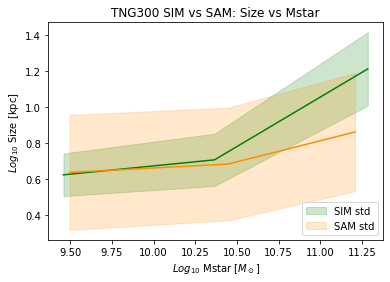

In [148]:
plt.plot(sim_mMstar, sim_mRstar, '-', color='green')

plt.fill_between(sim_mMstar, sim_mRstar - sim_stdRstar, sim_mRstar + sim_stdRstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mMstar, sam_mRstar, '-', color='darkorange')

plt.fill_between(sam_mMstar, sam_mRstar - sam_stdRstar, sam_mRstar + sam_stdRstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('TNG300 SIM vs SAM: Size vs Mstar')
plt.xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.ylabel('$ Log_{10} $ Size [kpc] ')
plt.legend(loc='lower right')
# plt.savefig('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SAM_Size_vs_Mstar_w_std_v2_wolastbin.jpeg', dpi=500)
plt.show()

### TNG100-OldSAM and SIM

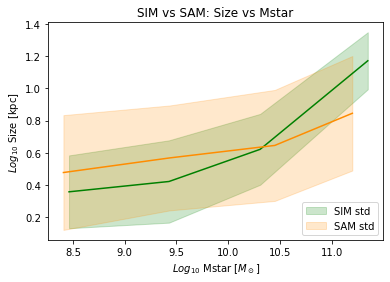

In [129]:
plt.plot(sim_mMstar, sim_mRstar, '-', color='green')

plt.fill_between(sim_mMstar, sim_mRstar - sim_stdRstar, sim_mRstar + sim_stdRstar,
                 color='green', alpha=0.2, label='SIM std')

plt.plot(sam_mMstar, sam_mRstar, '-', color='darkorange')

plt.fill_between(sam_mMstar, sam_mRstar - sam_stdRstar, sam_mRstar + sam_stdRstar,
                 color='darkorange', alpha=0.2, label='SAM std')

plt.title('SIM vs SAM: Size vs Mstar')
plt.xlabel('$ Log_{10} $ Mstar $[M_\odot]$')
plt.ylabel('$ Log_{10} $ Size [kpc] ')
plt.legend(loc='lower right')
# plt.savefig('SIM_SAM_Size_vs_Mstar_w_std.jpeg', dpi=500)
plt.show()

### Save the arrays as df in order to use them for plotting purposes

In [151]:
sim_mMstar = np.array([ sim_mMstar_9_10, sim_mMstar_10_11, sim_mMstar_11_12])
print(sim_mMstar)
sim_stdMstar = np.array([ sim_stdMstar_9_10, sim_stdMstar_10_11, sim_stdMstar_11_12])
print(sim_stdMstar)
sim_mRstar = np.array([ sim_mRstar_9_10, sim_mRstar_10_11, sim_mRstar_11_12])
print(sim_mRstar)
sim_stdRstar = np.array([ sim_stdRstar_9_10, sim_stdRstar_10_11, sim_stdRstar_11_12])
print(sim_stdRstar)

[ 9.45953751 10.36554098 11.28446551]
[0.28983455 0.25621122 0.23663858]
[0.62303222 0.70631452 1.21176071]
[0.11858482 0.1450955  0.20368272]


In [150]:
sam_mMstar = np.array([ sam_mMstar_9_10, sam_mMstar_10_11, sam_mMstar_11_12])
print(sam_mMstar)
sam_stdMstar = np.array([ sam_stdMstar_9_10, sam_stdMstar_10_11, sam_stdMstar_11_12])
print(sam_stdMstar)
sam_mRstar = np.array([ sam_mRstar_9_10, sam_mRstar_10_11, sam_mRstar_11_12])
print(sam_mRstar)
sam_stdRstar = np.array([ sam_stdRstar_9_10, sam_stdRstar_10_11, sam_stdRstar_11_12])
print(sam_stdRstar)

[ 9.49622297 10.4492655  11.20805448]
[0.28380136 0.2809016  0.17520848]
[0.63646205 0.68330017 0.86133433]
[0.31949601 0.31314247 0.32842599]


In [152]:
df_sam_mean_vals = pd.DataFrame({'sam_mMstar': sam_mMstar, 'sam_stdMstar': sam_stdMstar, 'sam_mRstar':sam_mRstar, 'sam_stdRstar':sam_stdRstar  })

In [153]:
df_sam_mean_vals

,sam_mMstar,sam_stdMstar,sam_mRstar,sam_stdRstar
0,9.496223,0.283801,0.636462,0.319496
1,10.449266,0.280902,0.683300,0.313142
2,11.208054,0.175208,0.861334,0.328426


In [156]:
df_mean_vals = pd.DataFrame({'sam_mMstar': sam_mMstar, 'sam_stdMstar': sam_stdMstar, 
                             'sam_mRstar':sam_mRstar, 'sam_stdRstar':sam_stdRstar,
                             'sim_mMstar': sim_mMstar, 'sim_stdMstar': sim_stdMstar, 
                             'sim_mRstar':sim_mRstar, 'sim_stdRstar':sim_stdRstar})

In [157]:
df_mean_vals

,sam_mMstar,sam_stdMstar,sam_mRstar,sam_stdRstar,sim_mMstar,sim_stdMstar,sim_mRstar,sim_stdRstar
0,9.496223,0.283801,0.636462,0.319496,9.459538,0.289835,0.623032,0.118585
1,10.449266,0.280902,0.683300,0.313142,10.365541,0.256211,0.706315,0.145096
2,11.208054,0.175208,0.861334,0.328426,11.284466,0.236639,1.211761,0.203683


In [158]:
# df_mean_vals.to_csv('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SAM_mean_MstarRstar_vals_and_std.csv', index=False)

In [ ]:
# df_mean_vals = pd.read_csv('TNG300-SAM_images/v16_TNG300-SAM_SIM_size_vs_mass/v16_TNG300_SIM_SAM_mean_MstarRstar_vals_and_std.csv')